In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch.nn

In [2]:
# Load the trained model 
#model2 = torch.load('./CFExp/weights20.pt')
# Set the model to evaluate mode
#model2.eval()
#model = torch.load('./CFExp/weights.pt', map_location= 'cpu')
model0 = torch.load('./CFExp/weights.pt')
# Set the model to evaluate mode
model0.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [3]:
# wrap the output as a tuple, so can run through torchscript
class wrapper(torch.nn.Module):
    def __init__(self, model):
        super(wrapper, self).__init__()
        self.model = model
    
    def forward(self, input):
        results = []
        output = self.model(input)
        for k, v in output.items():
            results.append(v)
        return tuple(results)

model2 = wrapper(model0)

In [3]:
# Read the log file using pandas into a dataframe
df = pd.read_csv('./CFExp/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

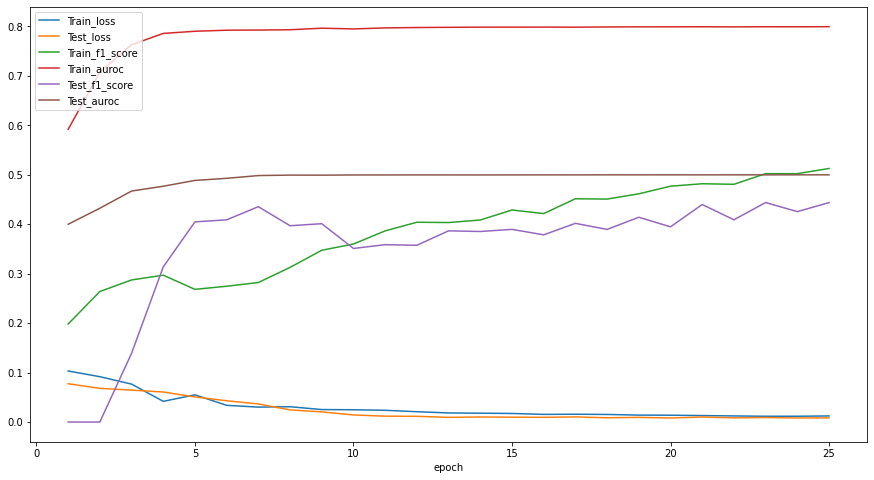

In [4]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8));

In [5]:
print(df[['Train_auroc','Test_auroc']].max())

Train_auroc    0.799335
Test_auroc     0.499816
dtype: float64


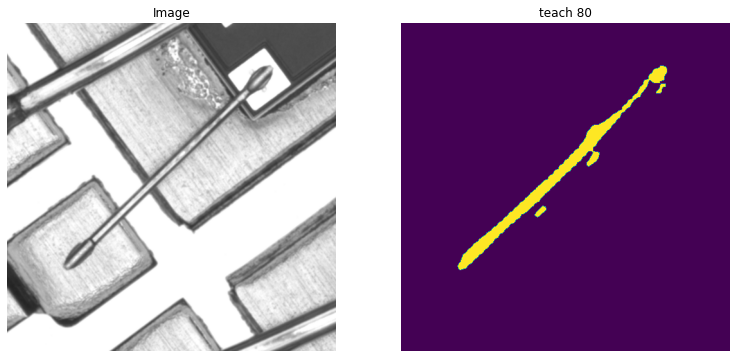

In [12]:
# Plot the input image, and output
plt.figure(figsize=(20,20));

ino = 1
# Read  a sample image and mask from the data-set
im0 = cv2.imread(f'./test1/{ino:04d}.png')
rows = im0.shape[0]
cols = im0.shape[1]
img = im0.transpose(2,0,1).reshape(1,3,rows,cols)
input1 = torch.from_numpy(img).type(torch.cuda.FloatTensor)/255
with torch.no_grad():
    a = model2(input1)
#    b = model2(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
cc = torch.sigmoid(a[0])
cc = a[0]
dd = cc.cpu().detach().numpy()[0][0]>0.2
plt.imshow(dd);
plt.title('teach 80')
plt.axis('off');
#plt.subplot(133);
#plt.imshow(b['out'].cpu().detach().numpy()[0][0]>0.2);
#plt.title('teach 20')
#plt.axis('off');

In [5]:
torch.cuda.is_available()
#cc = torch.sigmoid(a[0])
#cc, a[0]


True

In [37]:
import time
t1 = time.time()
input1 = torch.from_numpy(img).type(torch.cuda.FloatTensor)/255
t2 = time.time()
with torch.no_grad():
    a = model(input1)
t3 = time.time()
t2 - t1, t3-t2

(0.01937246322631836, 0.031914472579956055)

In [7]:
	traced_script_module = torch.jit.trace(model2, input1)
	traced_script_module.save("traced.pt")
